In [37]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
from sklearn.ensemble import IsolationForest
import seaborn as sns

In [38]:
period_order = [35, 36, 40, 39, 42, 43, 41, 46, 47, 44, 49, 50, 48, 53, 54, 51, 52, 56, 55, 58, 59, 57, 61]
period_order_name = ["2017-2018A", "2017-2018B", "2017-2018V", "2018-2019A", "2018-2019B", "2018-2019V",
                     "2019-2020A", "2019-2020B", "2019-2020V", "2020-2021A", "2020-2021B", "2020-2021V",
                     "2021-2022A", "2021-2022B", "2021-2022V", "2022-2023A", "2022-2023B", "2022-2023V",
                     "2023-2024A", "2023-2024B", "2023-2024V", "2024-2025A", "2024-2025B"]

# Mapear id_periodo a su nombre y tipo (A, B, V)
period_map = {id_p: name for id_p, name in zip(period_order, period_order_name)}
period_type = {id_p: name[-1] for id_p, name in zip(period_order, period_order_name)}

In [39]:
def load_period_csvs_into_vars(base_directory):
    """
    Carga los archivos CSV de calificaciones organizados por periodo y carrera
    en variables globales con el formato p<periodo>.
    Cada variable p<periodo> será un diccionario, donde las claves son los nombres
    de los archivos CSV (con el formato p<periodo>c<carrera>s<semestre>) y los
    valores son DataFrames de pandas.

    Args:
        base_directory (str): La ruta base donde se encuentran las carpetas de 'Periodo_XX'.

    Returns:
        dict: Un diccionario donde cada clave es 'p<periodo>' y su valor es otro
              diccionario que contiene los DataFrames de los CSVs de ese período.
              Retorna un diccionario vacío si no se encuentran archivos.
    """
    period_data = {}

    if not os.path.exists(base_directory):
        print(f"Error: El directorio base '{base_directory}' no existe.")
        return period_data

    # Iterate over Periodo folders
    for period_folder_name in os.listdir(base_directory):
        if period_folder_name.startswith("Periodo_"):
            period_id = period_folder_name.replace("Periodo_", "")
            period_path = os.path.join(base_directory, period_folder_name)

            if os.path.isdir(period_path):
                current_period_dfs = {}

                # Iterate over Carrera folders within the period folder
                for career_folder_name in os.listdir(period_path):
                    if career_folder_name.startswith("Carrera_"):
                        career_path = os.path.join(period_path, career_folder_name)

                        if os.path.isdir(career_path):
                            for file_name in os.listdir(career_path):
                                if file_name.endswith(".csv"):
                                    csv_path = os.path.join(career_path, file_name)
                                    parts = os.path.splitext(file_name)[0].split('periodo')[1].split('carrera')
                                    period_part = parts[0]
                                    career_sem_parts = parts[1].split('semestre')
                                    career_part = career_sem_parts[0]
                                    semestre_part = career_sem_parts[1]

                                    df_name = f"p{period_part}c{career_part}s{semestre_part}"

                                    try:
                                        df = pd.read_csv(csv_path)
                                        current_period_dfs[df_name] = df
                                        print(f"Cargado: {file_name} en p{period_id}['{df_name}']")
                                    except Exception as e:
                                        print(f"Error al cargar {file_name}: {e}")

                period_var_name = f"p{period_id}"
                period_data[period_var_name] = current_period_dfs
    
    if not period_data:
        print(f"No se encontraron datos de períodos en '{base_directory}'.")
        
    return period_data

In [40]:
csv_base_folder = r"D:/TesisDB/CSV's"

# --- Cargar todos los CSVs ---
print(f"Cargando datos desde: {csv_base_folder}")
all_period_data = load_period_csvs_into_vars(csv_base_folder)

Cargando datos desde: D:/TesisDB/CSV's
Cargado: periodo35carrera10semestre1.csv en p35['p35c10s1']
Cargado: periodo35carrera10semestre3.csv en p35['p35c10s3']
Cargado: periodo35carrera10semestre5.csv en p35['p35c10s5']
Cargado: periodo35carrera10semestre7.csv en p35['p35c10s7']
Cargado: periodo35carrera10semestre9.csv en p35['p35c10s9']
Cargado: periodo35carrera11semestre1.csv en p35['p35c11s1']
Cargado: periodo35carrera11semestre3.csv en p35['p35c11s3']
Cargado: periodo35carrera2semestre1.csv en p35['p35c2s1']
Cargado: periodo35carrera2semestre3.csv en p35['p35c2s3']
Cargado: periodo35carrera2semestre5.csv en p35['p35c2s5']
Cargado: periodo35carrera2semestre7.csv en p35['p35c2s7']
Cargado: periodo35carrera2semestre9.csv en p35['p35c2s9']
Cargado: periodo35carrera3semestre1.csv en p35['p35c3s1']
Cargado: periodo35carrera3semestre3.csv en p35['p35c3s3']
Cargado: periodo35carrera3semestre5.csv en p35['p35c3s5']
Cargado: periodo35carrera3semestre7.csv en p35['p35c3s7']
Cargado: periodo35c

In [41]:
# --- Algoritmo Isolation Forest ---
def apply_isolation_forest_to_grades(period_data, contamination=0.03):
    """
    Aplica Isolation Forest por periodo y carrera a estudiantes, usando
    promedios de sus calificaciones válidas (0-10) en todas las materias.

    Args:
        period_data (dict): Diccionario 'p<periodo>' con subdiccionarios de DataFrames.
        contamination (float): Proporción estimada de anomalías.

    Returns:
        dict: {(period_id, career_id): DataFrame con columna 'anomaly'}
    """
    anomaly_data = {}
    calif_cols = ['p1', 'p2', 'p3', 'o', 'pf', 'e1', 'e2', 'esp']

    for period_key, df_dict in period_data.items():
        try:
            period_id = int(period_key[1:])  # 'p58' → 58
        except ValueError:
            continue

        for df_name, df in df_dict.items():
            try:
                career_id = df_name.split('c')[1].split('s')[0]
            except IndexError:
                continue

            if 'matricula_hash' not in df.columns:
                continue

            # Seleccionar solo columnas válidas
            valid_cols = [col for col in calif_cols if col in df.columns]

            if not valid_cols:
                continue

            # Filtrar valores fuera del rango válido (0 a 10)
            df_clean = df.copy()
            for col in valid_cols:
                df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')
                df_clean.loc[(df_clean[col] < 0) | (df_clean[col] > 10), col] = None

            # Agrupar por estudiante: promedios de sus materias válidas
            student_avg = df_clean.groupby("matricula_hash")[valid_cols].mean().dropna()

            if student_avg.shape[0] < 1:
                # No tiene sentido aplicar Isolation Forest con muy pocos estudiantes
                continue

            try:
                iso_forest = IsolationForest(contamination=contamination, random_state=42)
                student_avg['anomaly'] = iso_forest.fit_predict(student_avg)
                student_avg['period_id'] = period_id
                student_avg['career_id'] = career_id

                anomaly_data[(period_id, career_id)] = student_avg

            except Exception as e:
                print(f"Error aplicando Isolation Forest en ({period_id}, {career_id}): {e}")

    return anomaly_data

In [42]:
def combine_anomaly_results(anomaly_data):
    """
    Combina todos los resultados de anomalías en un único DataFrame
    incluyendo las columnas period_id y career_id.

    Args:
        anomaly_data (dict): Diccionario {(period_id, career_id): DataFrame con 'anomaly'}

    Returns:
        DataFrame: Un único DataFrame con todos los resultados combinados.
    """
    all_dfs = []

    for (period_id, career_id), df in anomaly_data.items():
        df_copy = df.copy()
        df_copy['period_id'] = period_id
        df_copy['career_id'] = career_id
        all_dfs.append(df_copy)

    if all_dfs:
        combined_df = pd.concat(all_dfs, ignore_index=True)
        return combined_df
    else:
        return pd.DataFrame()  # Retorna vacío si no hubo datos

In [43]:
anomaly_data = apply_isolation_forest_to_grades(all_period_data, contamination=0.03)
# Datos
anomaly_data

{(35,
  '10'):                                                       p1     p2     p3    o  \
 matricula_hash                                                                
 19d769c96d396ba962c4bc75435456983edae31c3f9a3ef...  7.28  6.260  7.500  5.6   
 4238bbbef327745cabe1d4a16c4a2d30fec7e1573dc4f03...  7.56  6.525  6.675  6.0   
 
                                                       pf   e1   e2  esp  \
 matricula_hash                                                            
 19d769c96d396ba962c4bc75435456983edae31c3f9a3ef...  6.26  8.0  5.0  6.0   
 4238bbbef327745cabe1d4a16c4a2d30fec7e1573dc4f03...  5.38  5.4  3.0  6.0   
 
                                                     anomaly  period_id  \
 matricula_hash                                                           
 19d769c96d396ba962c4bc75435456983edae31c3f9a3ef...        1         35   
 4238bbbef327745cabe1d4a16c4a2d30fec7e1573dc4f03...        1         35   
 
                                                    care

In [44]:
combined_anomalies_df = combine_anomaly_results(anomaly_data)

In [45]:
combined_anomalies_df['anomaly'] = combined_anomalies_df['anomaly'].map({1: 0, -1: 1})  # Convertir a 0 y 1
# Convertir period_id a su nombre usando period_map
combined_anomalies_df['period_name'] = combined_anomalies_df['period_id'].map(period_map)
combined_anomalies_df

,p1,p2,p3,o,pf,e1,e2,esp,anomaly,period_id,career_id,period_name
0,7.280,6.260,7.500,5.60,6.260000,8.0,5.0,6.0,0,35,10,2017-2018A
1,7.560,6.525,6.675,6.00,5.380000,5.4,3.0,6.0,0,35,10,2017-2018A
2,3.700,2.875,4.825,3.70,3.725000,0.0,6.0,0.0,0,35,11,2017-2018A
3,8.320,6.600,4.480,6.44,5.533333,0.0,5.2,6.1,0,35,2,2017-2018A
4,8.600,7.450,6.740,6.74,6.900000,0.0,0.0,7.0,0,35,3,2017-2018A
...,...,...,...,...,...,...,...,...,...,...,...,...
268,2.000,2.000,4.000,2.00,2.300000,0.0,3.0,6.3,0,58,5,2023-2024B
269,1.600,3.600,3.400,7.00,4.900000,3.6,1.7,6.0,0,58,8,2023-2024B
270,6.700,4.720,3.680,5.10,4.820000,6.0,3.0,6.5,0,58,9,2023-2024B
271,4.125,5.100,3.200,3.60,3.800000,6.7,0.0,7.0,0,58,9,2023-2024B


In [46]:
normal = combined_anomalies_df[combined_anomalies_df['anomaly'] == 0]
normal

,p1,p2,p3,o,pf,e1,e2,esp,anomaly,period_id,career_id,period_name
0,7.280,6.260,7.500,5.60,6.260000,8.0,5.0,6.0,0,35,10,2017-2018A
1,7.560,6.525,6.675,6.00,5.380000,5.4,3.0,6.0,0,35,10,2017-2018A
2,3.700,2.875,4.825,3.70,3.725000,0.0,6.0,0.0,0,35,11,2017-2018A
3,8.320,6.600,4.480,6.44,5.533333,0.0,5.2,6.1,0,35,2,2017-2018A
4,8.600,7.450,6.740,6.74,6.900000,0.0,0.0,7.0,0,35,3,2017-2018A
...,...,...,...,...,...,...,...,...,...,...,...,...
267,6.000,2.500,4.500,4.00,4.100000,0.0,3.5,6.7,0,58,3,2023-2024B
268,2.000,2.000,4.000,2.00,2.300000,0.0,3.0,6.3,0,58,5,2023-2024B
269,1.600,3.600,3.400,7.00,4.900000,3.6,1.7,6.0,0,58,8,2023-2024B
270,6.700,4.720,3.680,5.10,4.820000,6.0,3.0,6.5,0,58,9,2023-2024B


In [47]:
anomalos = combined_anomalies_df[combined_anomalies_df['anomaly'] == 1]
anomalos.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32 entries, 5 to 272
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   p1           32 non-null     float64
 1   p2           32 non-null     float64
 2   p3           32 non-null     float64
 3   o            32 non-null     float64
 4   pf           32 non-null     float64
 5   e1           32 non-null     float64
 6   e2           32 non-null     float64
 7   esp          32 non-null     float64
 8   anomaly      32 non-null     int64  
 9   period_id    32 non-null     int64  
 10  career_id    32 non-null     object 
 11  period_name  32 non-null     object 
dtypes: float64(8), int64(2), object(2)
memory usage: 3.2+ KB


In [50]:
anomalos

,p1,p2,p3,o,pf,e1,e2,esp,anomaly,period_id,career_id,period_name
5,6.860000,7.075000,7.700000,6.400000,6.280000,3.000000,0.000000,6.0,1,35,3,2017-2018A
11,5.360000,7.480000,7.260000,5.420000,6.040000,3.666667,5.000000,6.0,1,35,8,2017-2018A
18,7.440000,6.380000,6.420000,6.740000,6.700000,0.000000,0.000000,0.0,1,35,9,2017-2018A
33,8.200000,6.140000,7.440000,7.600000,7.400000,0.000000,3.300000,2.5,1,36,10,2017-2018B
39,6.640000,6.820000,6.800000,8.160000,7.200000,1.800000,3.500000,1.5,1,36,3,2017-2018B
46,0.500000,1.000000,0.500000,0.000000,0.300000,0.500000,1.000000,7.5,1,36,5,2017-2018B
72,5.380000,5.200000,4.425000,5.680000,5.140000,3.500000,3.450000,3.2,1,36,8,2017-2018B
78,0.000000,4.000000,4.000000,4.100000,3.300000,0.000000,4.300000,6.0,1,36,9,2017-2018B
100,5.180000,5.980000,6.860000,7.660000,6.800000,2.000000,5.000000,4.1,1,39,3,2018-2019A
117,6.820000,6.420000,6.120000,5.240000,5.800000,4.850000,0.000000,6.0,1,39,5,2018-2019A


In [48]:
def plot_anomaly_distribution_by_period_career(df_combined):
    """
    Grafica la distribución de anomalías por combinación de periodo y carrera.

    Args:
        df_combined (DataFrame): DataFrame combinado con columnas 'period_id', 'career_id' y 'anomaly'.
    """
    if df_combined.empty:
        print("El DataFrame está vacío. No hay datos para graficar.")
        return

    # Crear etiqueta combinada "Periodo - Carrera"
    df_combined['periodo_carrera'] = df_combined['period_name'] + ' - ' + df_combined['career_id'].astype(str)

    # Reemplazar valores de anomalía para etiquetas
    df_combined['anomaly_label'] = df_combined['anomaly'].map({0: 'Normal', 1: 'Anomalía'})

    # Conteo agrupado
    grouped = df_combined.groupby(['periodo_carrera', 'anomaly_label']).size().reset_index(name='count')

    # Gráfica de barras apiladas por periodo-carrera
    plt.figure(figsize=(14, 8))
    sns.barplot(
        data=grouped,
        x='periodo_carrera',
        y='count',
        hue='anomaly_label',
        palette={'Normal': 'green', 'Anomalía': 'red'}
    )

    plt.title('Distribución de Anomalías por Periodo y Carrera')
    plt.xlabel('Periodo - Carrera')
    plt.ylabel('Número de Estudiantes')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.legend(title='Clasificación')
    plt.show()

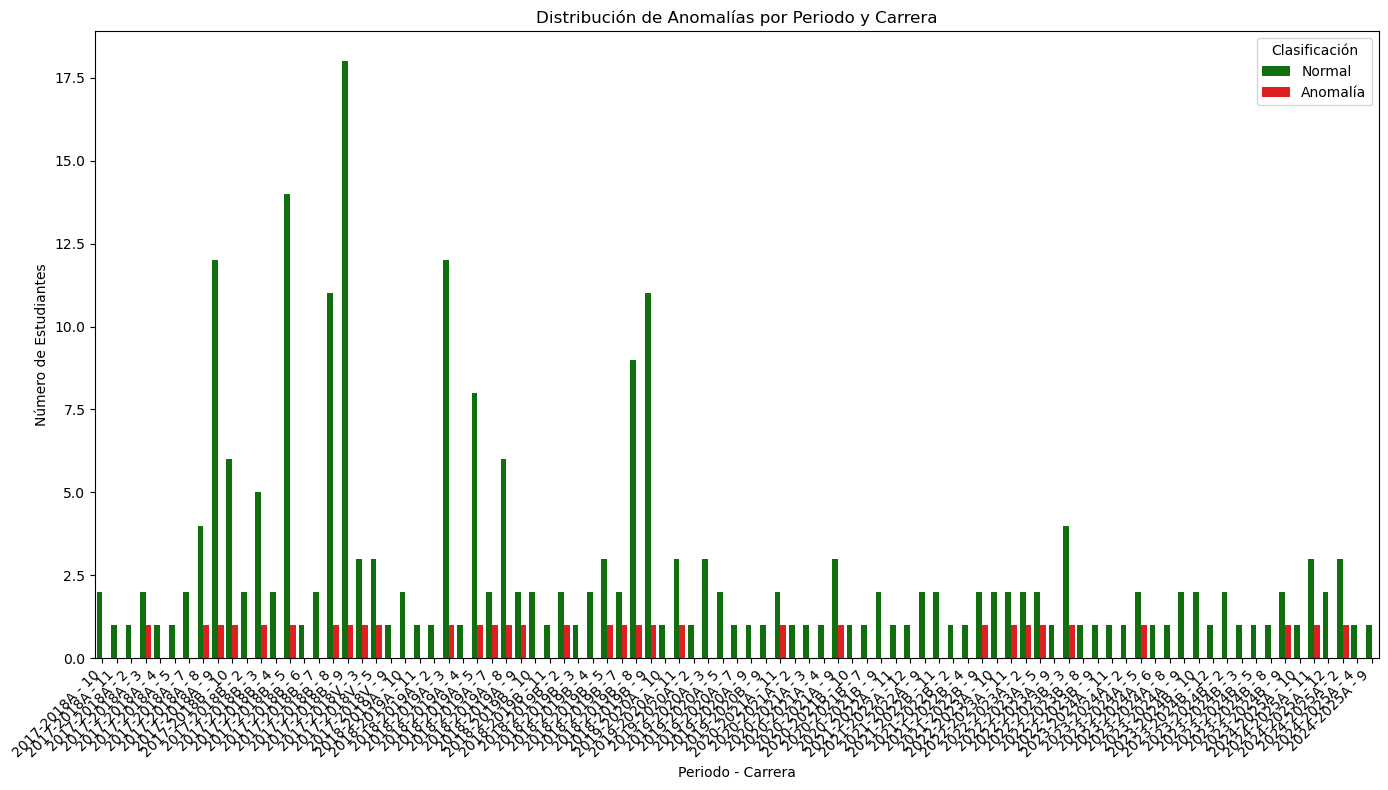

In [49]:
plot_anomaly_distribution_by_period_career(combined_anomalies_df)